In [1]:
import pandas as pd
import numpy as np
import pathlib
import os
import cv2
import seaborn as sns

import re
from collections import Counter

In [2]:

def get_image_paths(path_dir):
    tails = []
    image_tails = ["jpeg", "jpg", "JPG", "png"]
    image_paths = []
    for (dirpath, dirnames, filenames) in os.walk(path_dir):
 
        for filename in filenames:
            file_path = os.path.join(dirpath, filename)
            match = re.match(".*\.(.*)$", filename)
            if match != None:
                tail = match.group(1)
                if tail not in image_tails:
                    continue
                image_paths.append(file_path)
    return image_paths

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np

model = tf.keras.applications.vgg16.VGG16(weights='imagenet')

def extract_image_features(image_path):

    img = image.load_img(image_path, target_size=(224,224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    tf.keras.applications.vgg16.preprocess_input(x)

    features = model.predict(x)
    return features

def extract_image_features(image_paths):
    data = []
    for image_path in image_paths:
        img = image.load_img(image_path, target_size=(224,224))
        row = image.img_to_array(img)
        row = np.expand_dims(row, axis=0)
        data.append(row)
    all_data = np.concatenate(data, 0)
    x = tf.keras.applications.vgg16.preprocess_input(all_data)

    features = model.predict(x)
    return features

def get_image_color_features(image_paths, color_mode="grayscale"):
    data = []
    for image_path in image_paths:
        img = image.load_img(image_path, color_mode=color_mode ,target_size=(224,224))
        row = image.img_to_array(img)
        row = row.flatten()
        row = np.expand_dims(row, axis=0)
        data.append(row)
    all_data = np.concatenate(data, 0)

    return all_data

def compute_HOG_images(image_paths):
    data = []
    hog = cv2.HOGDescriptor()
    for image_path in image_paths:
        im = cv2.imread(image_path)
        im = cv2.resize(im,(224,224), interpolation = cv2.INTER_AREA)
        h = hog.compute(im)
        row = np.expand_dims(h, axis=0)
        data.append(row)
    all_data = np.concatenate(data, 0)

    return all_data

2022-02-16 13:09:21.951629: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/hondv/projects/CDD/hondv-otsv/venv/lib/python3.8/site-packages/cv2/../../lib64:
2022-02-16 13:09:21.951667: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-02-16 13:09:24.210125: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/hondv/projects/CDD/hondv-otsv/venv/lib/python3.8/site-packages/cv2/../../lib64:
2022-02-16 13:09:24.210175: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-02-16 13:09:24.210196: I tensorflow/stream_executor/cu

In [4]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from tqdm import tqdm

markers = {    "AV": "s", "Damage":"X"}
markers = ["s", "X"]
def analize_image_data(image_paths, output_path):
    rows = []
    for image_path in image_paths:
        img = cv2.imread(image_path)
        h,w, _ = img.shape
        image_type = None
        if "/AV/" in image_path:
            image_type = "AV"
        elif "/Damage/" in image_path:
            image_type = "Damage"
        else:
            image_type = "Damage"
        image_info = {"path": image_path, "height": h, "weight": w, "image_type":image_type}
        rows.append(image_info)
    df = pd.DataFrame(rows)
    

    print("-----Size of all images-----")
    print(df[["height", "weight"]].describe())
    for image_type in ["AV", "Damage"]:
        sub_df = df[df["image_type"] == image_type]
        print("-----Size of {} images-----".format(image_type))
        print(sub_df[["height", "weight"]].describe())
        
        
    sns.set_theme(style="ticks")
    df.to_csv(output_path, index=False)
    
    
    sns.pairplot(df, hue="image_type", markers=markers)
    
    
def get_image_feature(image_path: str):
    features = extract_image_features(image_path)
    return features[0]
def pca_analysis(data_path):
    df = pd.read_csv(data_path)
    image_types = df["image_type"].to_list()
    image_paths = df["path"].to_list()
    # features_data = [get_image_feature(image_path) for image/_path in tqdm(image_paths)]
    features_data = extract_image_features(image_paths)
    features_data = np.array(features_data)
    
    pca_data = PCA(n_components=2)
    principalComponents_data =  pca_data.fit_transform(features_data)
    pca_df = pd.DataFrame(data=principalComponents_data, columns = ["pca_1", "pca_2"])
    pca_df["y"] = image_types
    plt.figure(figsize=(16,10))
    sns.scatterplot(
        x="pca_1", y="pca_2",
        hue="y",
        data=pca_df,
        legend="full",
        style="y"
    ).set_title('Analyze PCA by features extraction of dataset')
    
def pca_color(data_path, color_mode=None):
    df = pd.read_csv(data_path)
    image_types = df["image_type"].to_list()
    image_paths = df["path"].to_list()
    # features_data = [get_image_feature(image_path) for image/_path in tqdm(image_paths)]
    features_data = get_image_color_features(image_paths,color_mode)
    features_data = np.array(features_data)
    
    pca_data = PCA(n_components=2)
    principalComponents_data =  pca_data.fit_transform(features_data)
    pca_df = pd.DataFrame(data=principalComponents_data, columns = ["pca_1", "pca_2"])
    pca_df["y"] = image_types
    plt.figure(figsize=(16,10))
    if color_mode == "grayscale":
        title = 'Analyze PCA by gray color images of dataset'
    else:
        title = 'Analyze PCA by BGR color images of dataset'
    sns.scatterplot(
        x="pca_1", y="pca_2",
        hue="y",
        data=pca_df,
        legend="full",
        style="y"
    ).set_title(title)
    
def pca_HOG_images(data_path):
    df = pd.read_csv(data_path)
    image_types = df["image_type"].to_list()
    image_paths = df["path"].to_list()
    # features_data = [get_image_feature(image_path) for image/_path in tqdm(image_paths)]
    features_data = compute_HOG_images(image_paths)
    features_data = np.array(features_data)
    
    pca_data = PCA(n_components=2)
    principalComponents_data =  pca_data.fit_transform(features_data)
    pca_df = pd.DataFrame(data=principalComponents_data, columns = ["pca_1", "pca_2"])
    pca_df["y"] = image_types
    plt.figure(figsize=(16,10))
    sns.scatterplot(
        x="pca_1", y="pca_2",
        hue="y",
        data=pca_df,
        legend="full",
        style="y"
    ).set_title('Analyze PCA by HOG computation of dataset')
    

In [5]:
from random import randrange
print()
def show_image(data_path, image_type):
    df = pd.read_csv(data_path)
    df = df[df["image_type"]==image_type]
    image_paths = df["path"].to_list()
    # create figure
    fig = plt.figure(figsize=(10, 7))
    len_segment = int(len(image_paths) / 9)
    # setting values to rows and column variables
    rows = 3
    columns = 3
    rand_values = randrange(len_segment)
    print("random values:", rand_values)
    # reading images
    print("len_segment:", len_segment)
    Images = [cv2.imread(image_paths[i*len_segment + rand_values]) for i in range(9)]
    Images = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in Images]
    for i in range(9):
        
        # Adds a subplot at the 1st position
        fig.add_subplot(rows, columns, i + 1)

        # showing image
        plt.imshow(Images[i])
        plt.axis('off')
        # plt.title("First")


-----Size of all images-----
            height       weight
count  2012.000000  2012.000000
mean    968.683897   733.455268
std     519.838561   310.867802
min     150.000000   187.000000
25%     600.000000   640.000000
50%    1040.000000   720.000000
75%    1280.000000   800.000000
max    4032.000000  4864.000000
-----Size of AV images-----
            height       weight
count   313.000000   313.000000
mean   1232.396166   805.166134
std     461.601806   241.757211
min     683.000000   585.000000
25%    1040.000000   720.000000
50%    1280.000000   720.000000
75%    1280.000000   780.000000
max    4032.000000  1816.000000
-----Size of Damage images-----
            height       weight
count  1699.000000  1699.000000
mean    920.101236   720.244261
std     515.472955   320.297978
min     150.000000   187.000000
25%     600.000000   640.000000
50%    1040.000000   720.000000
75%    1280.000000   800.000000
max    4032.000000  4864.000000


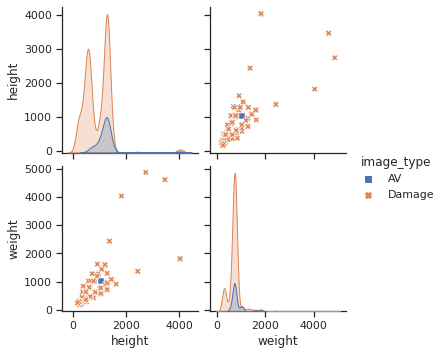

In [6]:
path = "/mnt/c/Users/hon.dangv/Desktop/data/CDD/depots/MNR container picture DB/Container Damage Detection Study-20220208T101749Z-001/Container Damage Detection Study"
image_paths = get_image_paths(path)
output_path = "/mnt/c/Users/hon.dangv/Desktop/data/CDD/depots/MNR container picture DB/Container Damage Detection Study-20220208T101749Z-001/Container Damage Detection Study/analisis_result_2-11-2022.csv"

analize_image_data(image_paths,output_path)

dataset has medium image size is (1040, 720).
amount images with type "Damage" are 3 times than "AV" images.


### Set input_path is the folder of dataset about Container Damage Detection

In [ ]:
# Set input_path is the folder of dataset which contains 2 sub-folders: "AV" and "Damage 
input_path = "/mnt/c/Users/hon.dangv/Desktop/data/CDD/depots/MNR container picture DB/Container Damage Detection Study-20220208T101749Z-001/Container Damage Detection Study/analisis_result_2-11-2022.csv"
pca_analysis(input_path)

"Damage" images are variable than "AV" images

In [ ]:
input_path = "/mnt/c/Users/hon.dangv/Desktop/data/CDD/depots/MNR container picture DB/Container Damage Detection Study-20220208T101749Z-001/Container Damage Detection Study/analisis_result_2-11-2022.csv"
pca_color(input_path,color_mode="grayscale")

The brightness of the two data types is similar

In [ ]:
input_path = "/mnt/c/Users/hon.dangv/Desktop/data/CDD/depots/MNR container picture DB/Container Damage Detection Study-20220208T101749Z-001/Container Damage Detection Study/analisis_result_2-11-2022.csv"
pca_color(input_path,color_mode="rgb")

The color diversity of the two data types is similar

In [ ]:
input_path = "/mnt/c/Users/hon.dangv/Desktop/data/CDD/depots/MNR container picture DB/Container Damage Detection Study-20220208T101749Z-001/Container Damage Detection Study/analisis_result_2-11-2022.csv"
pca_HOG_images(input_path)


using HOG calculation makes the 2 types of images more distinct


In [ ]:
show_image(input_path, image_type="AV")

In [ ]:
show_image(input_path, image_type="Damage")